# LLM - Detect AI Generated Text

In the past few years, significant advancements have been made in the development of large language models (LLMs). These models have reached a level of sophistication where the text they generate closely resembles that of human authors. This notebook explores machine learning models that can effectively determine whether an essay was authored by a student or generated by a large language model. 

The dataset includes a mixture of essays composed by students and those produced by various LLMs.

## Acknowledgments

Vanderbilt University and the Learning Agency Lab would like to thank the Bill & Melinda Gates Foundation, Schmidt Futures, and Chan Zuckerberg Initiative for their support in making this work possible.

Jules King, Perpetual Baffour, Scott Crossley, Ryan Holbrook, Maggie Demkin. (2023). LLM - Detect AI Generated Text. Kaggle. https://kaggle.com/competitions/llm-detect-ai-generated-text

# Table of Contents

- [Imports](#imports)
- [Load Data](#load-data)
- [EDA](#eda)
  - [train_prompts](#train-prompts)
  - [train_essays](#train-essays)

<a id="imports"></a>
# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.metrics import BigramAssocMeasures
from nltk.util import ngrams
import re

nltk.download('punkt')
# Load the English language model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="load"></a>
# Load Data

{test|train}_essays.csv
- `id` - A unique identifier for each essay.
- `prompt_id` - Identifies the prompt the essay was written in response to.
- `text` - The essay text itself.
- `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

train_prompts.csv - Essays were written in response to information in these fields.
- `prompt_id` - A unique identifier for each prompt.
- `prompt_name` - The title of the prompt.
- `instructions` - The instructions given to students.
- `source_text` - The text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in `0 Paragraph one.\n\n1 Paragraph two.`. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like `# Title`. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like `## Subheading`.

In [2]:
train_prompts = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
# Load the training and testing datasets
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

<a id="eda"></a>
# EDA

- Word cloud visualizations to identify frequently occurring words in each type of essay.
- Text analysis to understand the linguistic characteristics of the essays, e.g. calculating word counts, average sentence lengths, and vocabulary richness.

<a id="train-prompts"></a>
## train_prompts

There are 2 prompts provided in `train_prompts`, each with a question, instructions, and 3-4 reading passages to serve as source texts.

In [3]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


<a id="train-essays"></a>
## train_essays

- No missing values
- 1378 essays, of which 3 are generated 

In [4]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
# 1378 essays in total
train_essays.shape

(1378, 4)

In [6]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


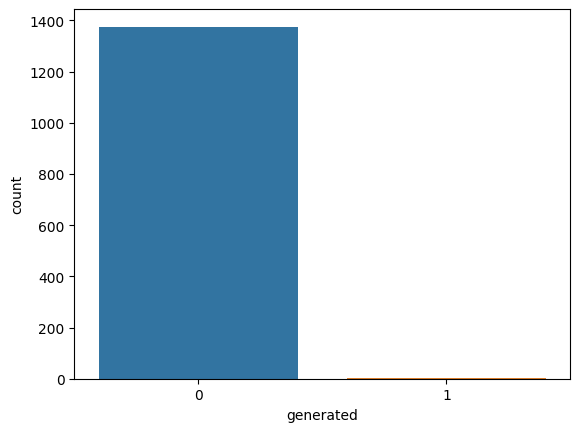

In [7]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

In [8]:
train_essays.groupby(['generated']).count().reset_index()

,generated,id,prompt_id,text
0,0,1375,1375,1375
1,1,3,3,3


### Word Cloud

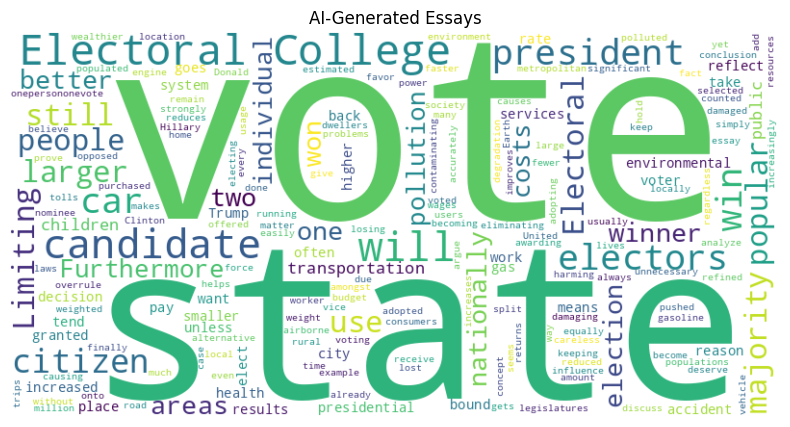

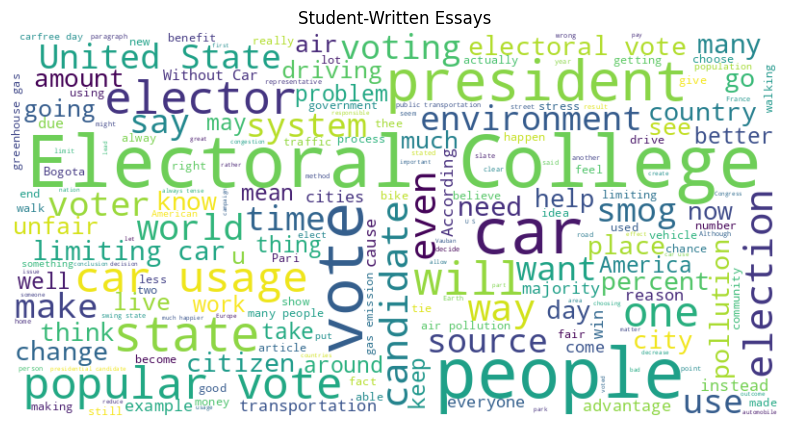

In [9]:
# Separate AI-generated and student-written essays
ai_generated_essays = train_essays[train_essays['generated'] == 1]
student_essays = train_essays[train_essays['generated'] == 0]

# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create word clouds for AI-generated and student-written essays
generate_wordcloud(" ".join(ai_generated_essays['text']), "AI-Generated Essays")
generate_wordcloud(" ".join(student_essays['text']), "Student-Written Essays")

#### Average Word Length

In [10]:
# Define a function to calculate the average word length
def average_word_length(text):
    words = text.split()
    total_word_length = sum(len(word) for word in words)
    return round(total_word_length / len(words), 2)

# Apply the function to create a new 'avg_word_length' column
train_essays['avg_word_length'] = train_essays['text'].apply(average_word_length)

# Calculate the median average word length for generated and non-generated essays
median_avg_word_length = train_essays.groupby(['generated'])['avg_word_length'].median().reset_index()
median_avg_word_length

,generated,avg_word_length
0,0,4.69
1,1,4.82


#### Unique words

In [11]:
# Define a function to calculate the number of unique words
def nr_unique_words(text):
    words = text.split()
    unique_words = set(word.lower() for word in words)
    return len(unique_words)

# Apply the function to create a new 'uniq_word_count' column
train_essays['uniq_word_count'] = train_essays['text'].apply(nr_unique_words)

# Calculate the median unique word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['uniq_word_count'].median().reset_index()
median_word_count

,generated,uniq_word_count
0,0,251.0
1,1,117.0


#### Word Count

In [12]:
# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Apply the function to create a new 'word_count' column
train_essays['word_count'] = train_essays['text'].apply(word_count)

# Calculate the median word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['word_count'].median().reset_index()
median_word_count

,generated,word_count
0,0,525.0
1,1,258.0


#### Stop Word Count

In [13]:
# Function to count stop words
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    stop_words_count = sum(1 for word in words if word.lower() in stop_words)
    return stop_words_count

# Apply the function to create a new 'stop_word_count' column
train_essays['stop_word_count'] = train_essays['text'].apply(count_stop_words)

# Calculate the count of stop words for generated and non-generated essays
stop_word_count = train_essays.groupby(['generated'])['stop_word_count'].mean().reset_index()
stop_word_count

,generated,stop_word_count
0,0,265.331636
1,1,122.666667


#### Number of Sentences

In [14]:
# Define a function to count sentences
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Apply the function to create a new 'nr_sentences' column
train_essays['nr_sentences'] = train_essays['text'].apply(count_sentences)

# Calculate the mean number of sentences for generated and non-generated essays
mean_sentence_count = train_essays.groupby(['generated'])['nr_sentences'].mean().reset_index()
mean_sentence_count

,generated,nr_sentences
0,0,27.658182
1,1,12.333333


#### Average Number of Clauses

In [15]:
# Define a function to calculate sentence complexity based on clauses
def sentence_complexity_clauses(text):
    sentences = sent_tokenize(text)
    clause_counts = [len(TreebankWordTokenizer().tokenize(sentence)) for sentence in sentences]
    avg_clause_count = sum(clause_counts) / len(sentences)
    return round(avg_clause_count, 2)

# Apply the function to create a new 'sentence_complexity_clauses' column
train_essays['sentence_complexity_clauses'] = train_essays['text'].apply(sentence_complexity_clauses)

# Calculate the mean sentence complexity based on clauses for generated and non-generated essays
mean_sentence_complexity_clauses = train_essays.groupby(['generated'])['sentence_complexity_clauses'].mean().reset_index()
mean_sentence_complexity_clauses

,generated,sentence_complexity_clauses
0,0,23.275105
1,1,23.250000


#### Voabulary Richness

TTR is the ratio of the number of unique words (types) to the total number of words (tokens) in a text.

In [16]:
# Preprocess the text by lowercasing, removing punctuation, and newline characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Remove newline characters and replace with a space
    return text

# Define a function to calculate type-token ratio (TTR)
def calculate_ttr(text):
    words = word_tokenize(text)
    total_tokens = len(words)
    unique_tokens = len(set(words))
    ttr = unique_tokens / total_tokens
    return ttr

# Preprocess the text column
train_essays['preprocessed_text'] = train_essays['text'].apply(preprocess_text)

# Calculate TTR and create a new 'ttr' column
train_essays['ttr'] = train_essays['preprocessed_text'].apply(calculate_ttr)

# Calculate the mean TTR for generated and non-generated essays
mean_ttr = train_essays.groupby(['generated'])['ttr'].mean().reset_index()
mean_ttr

,generated,ttr
0,0,0.435546
1,1,0.502483


#### Paragraph Length

In [17]:
# Define a function to analyze the average length of paragraphs
def average_paragraph_length(text):
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by two newline characters
    paragraph_lengths = [len(sent_tokenize(paragraph)) for paragraph in paragraphs if paragraph.strip()]  # Exclude empty paragraphs
    avg_paragraph_length = sum(paragraph_lengths) / len(paragraphs)
    return round(avg_paragraph_length, 2)

# Apply the function to create a new 'avg_paragraph_length' column
train_essays['avg_paragraph_length'] = train_essays['text'].apply(average_paragraph_length)

# Calculate the mean average paragraph length for generated and non-generated essays
mean_avg_paragraph_length = train_essays.groupby(['generated'])['avg_paragraph_length'].mean().reset_index()
mean_avg_paragraph_length

,generated,avg_paragraph_length
0,0,5.89576
1,1,9.00000
